In [3]:
import sys
import os
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import h5py

# Import BIND and utilities
from bind.bind import BIND
from bind.workflow_utils import ConfigLoader, load_normalization_stats

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'bind'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/bind


## Configuration

In [ ]:
# ============================================================================
# CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type: 'clean' (3-channel joint) or 'triple' (3 separate VDMs)
MODEL_TYPE = 'triple'

# Config file path
if MODEL_TYPE == 'clean':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_aggressive_stellar.ini'
else:
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_triple.ini'

# CV simulation to process
SIM_NUM = 12  # Choose from 0-26 (excluding 17)

# Simulation paths
CAMELS_ROOT = Path('/mnt/ceph/users/camels')
DMO_PATH = CAMELS_ROOT / 'Sims' / 'IllustrisTNG_DM' / 'L50n512' / 'CV' / f'CV_{SIM_NUM}'
HYDRO_PATH = CAMELS_ROOT / 'Sims' / 'IllustrisTNG' / 'L50n512' / 'CV' / f'CV_{SIM_NUM}'

# Snapshot number (90 = z=0 for CAMELS)
SNAPNUM = 90

# Grid parameters
BOX_SIZE = 50000.0  # kpc/h
GRID_SIZE = 1024

# Number of realizations (multiple for uncertainty quantification)
N_REALIZATIONS = 10

# Output directory for BIND results
OUTPUT_DIR = Path(f'/mnt/home/mlee1/ceph/BIND2d/CV/sim_{SIM_NUM}')

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"CV Simulation: {SIM_NUM}")
print(f"DMO path: {DMO_PATH}")
print(f"Hydro path: {HYDRO_PATH}")
print(f"Number of realizations: {N_REALIZATIONS}")

Model type: triple
Config: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini
CV Simulation: 12
DMO path: /mnt/ceph/users/camels/Sims/IllustrisTNG_DM/L50n512/CV/CV_12
Hydro path: /mnt/ceph/users/camels/Sims/IllustrisTNG/L50n512/CV/CV_12


## Load Cosmological Parameters

In [5]:
import pandas as pd

# Load parameter bounds for normalization
param_path = '/mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv'
if Path(param_path).exists():
    param_df = pd.read_csv(param_path)
    fiducial_params = list(param_df['FiducialVal'])
    print(f"Loaded {len(fiducial_params)} cosmological parameters")
else:
    fiducial_params = None
    print("Warning: Parameter file not found, using None")

Loaded 35 cosmological parameters


## Initialize BIND Pipeline

In [6]:
# Initialize BIND
bind = BIND(
    simulation_path=str(DMO_PATH),
    snapnum=SNAPNUM,
    boxsize=BOX_SIZE,
    gridsize=GRID_SIZE,
    config_path=str(CONFIG_PATH),
    output_dir=str(OUTPUT_DIR),
    verbose=True,
    dim='2d',
    axis=2,  # Project along z-axis
    r_in_factor=2,
    r_out_factor=3,
    mass_threshold=1e13
)

[BIND] 🌟 Quantile normalization enabled: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
[BIND] Loaded large_scale_channels from config: 3
✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
[BIND] Loaded normalization from .npz files:
  DM condition: mean=9.977704, std=0.413852
  DM target:   mean=9.915499, std=0.467967
  Gas target:  mean=9.177344, std=0.410510
  Stars target: QUANTILE TRANSFORMATION (/mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl)
[BIND] Initialized BIND pipeline.


## Run BIND Pipeline

In [7]:
# Step 1: Voxelize DMO simulation
print("Step 1: Voxelizing DMO simulation...")
bind.voxelize_simulation()

Step 1: Voxelizing DMO simulation...
[BIND] Voxelizing simulation...
[BIND] Projection complete. Grid shape: (1024, 1024)


array([[5.5956754e+10, 1.3322732e+10, 5.8497321e+09, ..., 5.4223611e+09,
        1.0709911e+10, 3.0770969e+10],
       [1.3284944e+10, 7.8587745e+09, 5.1074058e+09, ..., 6.9306716e+09,
        8.3618017e+09, 1.2243237e+10],
       [6.8792617e+09, 6.9898450e+09, 5.5694746e+09, ..., 9.1248835e+09,
        1.2867231e+10, 6.3512074e+09],
       ...,
       [4.7728635e+09, 5.6213770e+09, 3.9741025e+09, ..., 5.6735360e+09,
        5.4177879e+09, 3.9854152e+09],
       [5.1273805e+09, 4.7000893e+09, 4.5768468e+09, ..., 4.9307663e+09,
        4.7282642e+09, 4.8257674e+09],
       [2.1245270e+10, 7.9257364e+09, 5.0658939e+09, ..., 4.3124767e+09,
        5.7693993e+09, 1.2790413e+10]], dtype=float32)

In [8]:
# Step 2: Extract halos with large-scale conditioning
print("\nStep 2: Extracting halos...")
bind.extract_halos(omega_m=0.3, use_large_scale=True, num_large_scales=3)

# Get number of halos
num_halos = len(bind.extracted['metadata'])
print(f"Extracted {num_halos} halos")


Step 2: Extracting halos...
[BIND] Loading halo catalog from /mnt/ceph/users/camels/FOF_Subfind/IllustrisTNG_DM/L50n512/CV/CV_12/fof_subhalo_tab_090.hdf5
[BIND] Loaded 36 halos above mass threshold.
[BIND] Extracting halos...
[BIND] Extracting condition at 6.25 Mpc + 3 large-scale map(s) at [12.5, 25.0, 50.0] Mpc, 128^2 resolution...
[BIND] Extracted 36 halos.
Extracted 36 halos


In [9]:
# Prepare conditional parameters (repeat for each halo)
if fiducial_params is not None:
    conditional_params = np.tile(fiducial_params, (num_halos, 1))
else:
    conditional_params = None

In [33]:
N_REALIZATIONS = 16

In [ ]:
# Step 3: Generate baryonic fields
print("\nStep 3: Generating baryonic fields...")
generated_halos = bind.generate_halos(
    batch_size=N_REALIZATIONS,
    conditional_params=conditional_params,
    use_large_scale=True,
    conserve_mass=True
)

Seed set to 42



Step 3: Generating baryonic fields...
[BIND] Generating halos with diffusion model...
[BIND] Using large-scale conditioning
[BIND] Mass conservation enabled: generated (DM+Gas+Stars) will match DMO cutout mass
[ConfigLoader] Converted legacy_fourier=False to fourier_legacy
[ConfigLoader] conditioning_channels not in config or None, using default: 1
[ConfigLoader] 🌟 Quantile normalization enabled: data/quantile_normalizer_stellar.pkl
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini
[ConfigLoader] Parameters:
  seed: 42
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 42
  num_workers: 40
  cropsize: 128
  max_epochs: 250
  learning_rate: 5e-05
  lr_scheduler: cosine_warmup
  noise_schedule: learned_nn
  gamma_min: -13.3
  gamma_max: 13.0
  data_noise: 0.0005
  antithetic_time_sampling: True
  n_blocks: 5
  embedding_dim: 96
  norm_groups: 8
  n_attention_heads:

Generating Samples:   0%|          | 0/36 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:981: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples: 100%|██████████| 36/36 [18:34<00:00, 30.95s/it]


torch.Size([36, 16, 3, 128, 128])


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version

[BIND] Cleaning up 36 halo condition files...
[BIND] Generated 36 halo sets.


In [44]:
# Step 4: Paste halos back to full box
print("\nStep 4: Pasting halos to full box...")
final_maps = bind.paste_halos(
    realizations=N_REALIZATIONS,
    use_enhanced=True
)

print(f"Generated {len(final_maps)} realization(s)")
print(f"Final map shape: {final_maps[0].shape}")


Step 4: Pasting halos to full box...
[BIND] Pasting halos...
[BIND] Pasting complete. Generated 16 realizations.
Generated 16 realization(s)
Final map shape: (1024, 1024)
[BIND] Pasting complete. Generated 16 realizations.
Generated 16 realization(s)
Final map shape: (1024, 1024)


## Load Hydro Ground Truth

In [35]:
def load_hydro_maps(sim_num, precomputed_dir='/mnt/home/mlee1/ceph/BIND2d_new/CV/'):
    """
    Load pre-processed hydro simulation fields from saved .npy files.
    
    The full_hydro.npy contains the HYDRO DM field (dark matter from the
    matched hydrodynamic simulation), which is what we compare against for
    power spectrum analysis.
    
    Args:
        sim_num: CV simulation number (0-26)
        precomputed_dir: Directory containing pre-processed simulation files
    
    Returns:
        dict with 'dm' (hydro DM), 'dmo' (dark matter only) fields
    """
    sim_dir = Path(precomputed_dir) / f'sim_{sim_num}/snap_{SNAPNUM}/'
    
    fields = {}
    
    # Load hydro DM field (this is the matched hydro simulation's DM)
    hydro_path = sim_dir / 'full_hydro.npy'
    if hydro_path.exists():
        fields['hydro'] = np.load(hydro_path)
        print(f"Loaded hydro from: {hydro_path}")
    else:
        print(f"Warning: full_hydro.npy not found at {hydro_path}")
    
    # Load DMO field for reference
    dmo_path = sim_dir / 'sim_grid.npy'
    if dmo_path.exists():
        fields['dmo'] = np.load(dmo_path)
        print(f"Loaded DMO from: {dmo_path}")
    else:
        print(f"Warning: sim_grid.npy not found at {dmo_path}")
    
    return fields

In [37]:
# Load pre-processed hydro ground truth
print("Loading hydro ground truth from pre-processed files...")
try:
    hydro_fields = load_hydro_maps(SIM_NUM)
    print(f"Loaded hydro fields: {list(hydro_fields.keys())}")
    for name, field in hydro_fields.items():
        print(f"  {name}: {field.shape}, sum={field.sum():.2e}")
except Exception as e:
    print(f"Failed to load hydro: {e}")
    hydro_fields = None

Loading hydro ground truth from pre-processed files...
Loaded hydro from: /mnt/home/mlee1/ceph/BIND2d_new/CV/sim_12/snap_90/full_hydro.npy
Loaded DMO from: /mnt/home/mlee1/ceph/BIND2d_new/CV/sim_12/snap_90/sim_grid.npy
Loaded hydro fields: ['hydro', 'dmo']
  hydro: (1024, 1024), sum=1.04e+16
  dmo: (1024, 1024), sum=1.04e+16


## Power Spectrum Computation

In [38]:
def compute_power_spectrum_2d(field, box_size_mpc, n_bins=50):
    """
    Compute 2D power spectrum using FFT.
    
    Args:
        field: 2D density field
        box_size_mpc: Box size in Mpc/h
        n_bins: Number of k bins
    
    Returns:
        k: Wavenumber array in h/Mpc
        Pk: Power spectrum P(k)
    """
    N = field.shape[0]
    
    # Compute FFT
    fft_field = np.fft.fft2(field)
    fft_field = np.fft.fftshift(fft_field)
    
    # Power spectrum
    power = np.abs(fft_field)**2
    
    # Create k grid
    kx = np.fft.fftfreq(N, d=box_size_mpc/N) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=box_size_mpc/N) * 2 * np.pi
    kx = np.fft.fftshift(kx)
    ky = np.fft.fftshift(ky)
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    k_mag = np.sqrt(kx_grid**2 + ky_grid**2)
    
    # Bin the power spectrum
    k_min = 2 * np.pi / box_size_mpc
    k_max = np.pi * N / box_size_mpc
    k_bins = np.logspace(np.log10(k_min), np.log10(k_max), n_bins + 1)
    k_centers = np.sqrt(k_bins[:-1] * k_bins[1:])
    
    Pk = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (k_mag >= k_bins[i]) & (k_mag < k_bins[i+1])
        if mask.sum() > 0:
            Pk[i] = power[mask].mean()
            counts[i] = mask.sum()
    
    # Normalize
    Pk *= (box_size_mpc / N)**2
    
    # Remove empty bins
    valid = counts > 0
    
    return k_centers[valid], Pk[valid]

In [39]:
# Convert box size to Mpc/h
box_size_mpc = BOX_SIZE / 1000.0

# Compute power spectra
print("Computing power spectra...")

# DMO power spectrum
dmo_field = bind.sim_grid
k_dmo, Pk_dmo = compute_power_spectrum_2d(dmo_field, box_size_mpc)
print(f"  DMO: k range [{k_dmo.min():.3f}, {k_dmo.max():.1f}] h/Mpc")

# BIND power spectra for ALL realizations
print(f"  Computing BIND power spectra for {len(final_maps)} realizations...")
Pk_bind_all = []  # List to store P(k) for each realization
k_bind = None

for i, bind_map in enumerate(final_maps):
    if bind_map.ndim == 3:  # (3, H, W) -> sum to total
        bind_total_i = bind_map.sum(axis=0)
    else:
        bind_total_i = bind_map
    
    k_i, Pk_i = compute_power_spectrum_2d(bind_total_i, box_size_mpc)
    Pk_bind_all.append(Pk_i)
    
    if k_bind is None:
        k_bind = k_i  # All realizations should have same k

Pk_bind_all = np.array(Pk_bind_all)  # Shape: (N_REALIZATIONS, n_k)
print(f"  BIND: computed {len(final_maps)} realizations, Pk shape: {Pk_bind_all.shape}")

# Compute mean and std of BIND power spectra
Pk_bind_mean = Pk_bind_all.mean(axis=0)
Pk_bind_std = Pk_bind_all.std(axis=0)

# For backwards compatibility, also set bind_total to first realization
bind_field = final_maps[0]
if bind_field.ndim == 3:
    bind_total = bind_field.sum(axis=0)
else:
    bind_total = bind_field

# Hydro power spectra (if available)
Pk_hydro = {}
if hydro_fields is not None:
    field = hydro_fields['dmo']
    k, Pk = compute_power_spectrum_2d(field, box_size_mpc)
    Pk_hydro['dm'] = (k, Pk)
    
    # Total hydro
    hydro_total = hydro_fields['hydro']
    k_hydro, Pk_hydro_total = compute_power_spectrum_2d(hydro_total, box_size_mpc)
    Pk_hydro['total'] = (k_hydro, Pk_hydro_total)
    print(f"  Hydro: computed all channels")

Computing power spectra...
  DMO: k range [0.134, 60.4] h/Mpc
  Computing BIND power spectra for 16 realizations...
  BIND: computed 16 realizations, Pk shape: (16, 46)
  BIND: computed 16 realizations, Pk shape: (16, 46)
  Hydro: computed all channels
  Hydro: computed all channels


## Plot Power Spectra

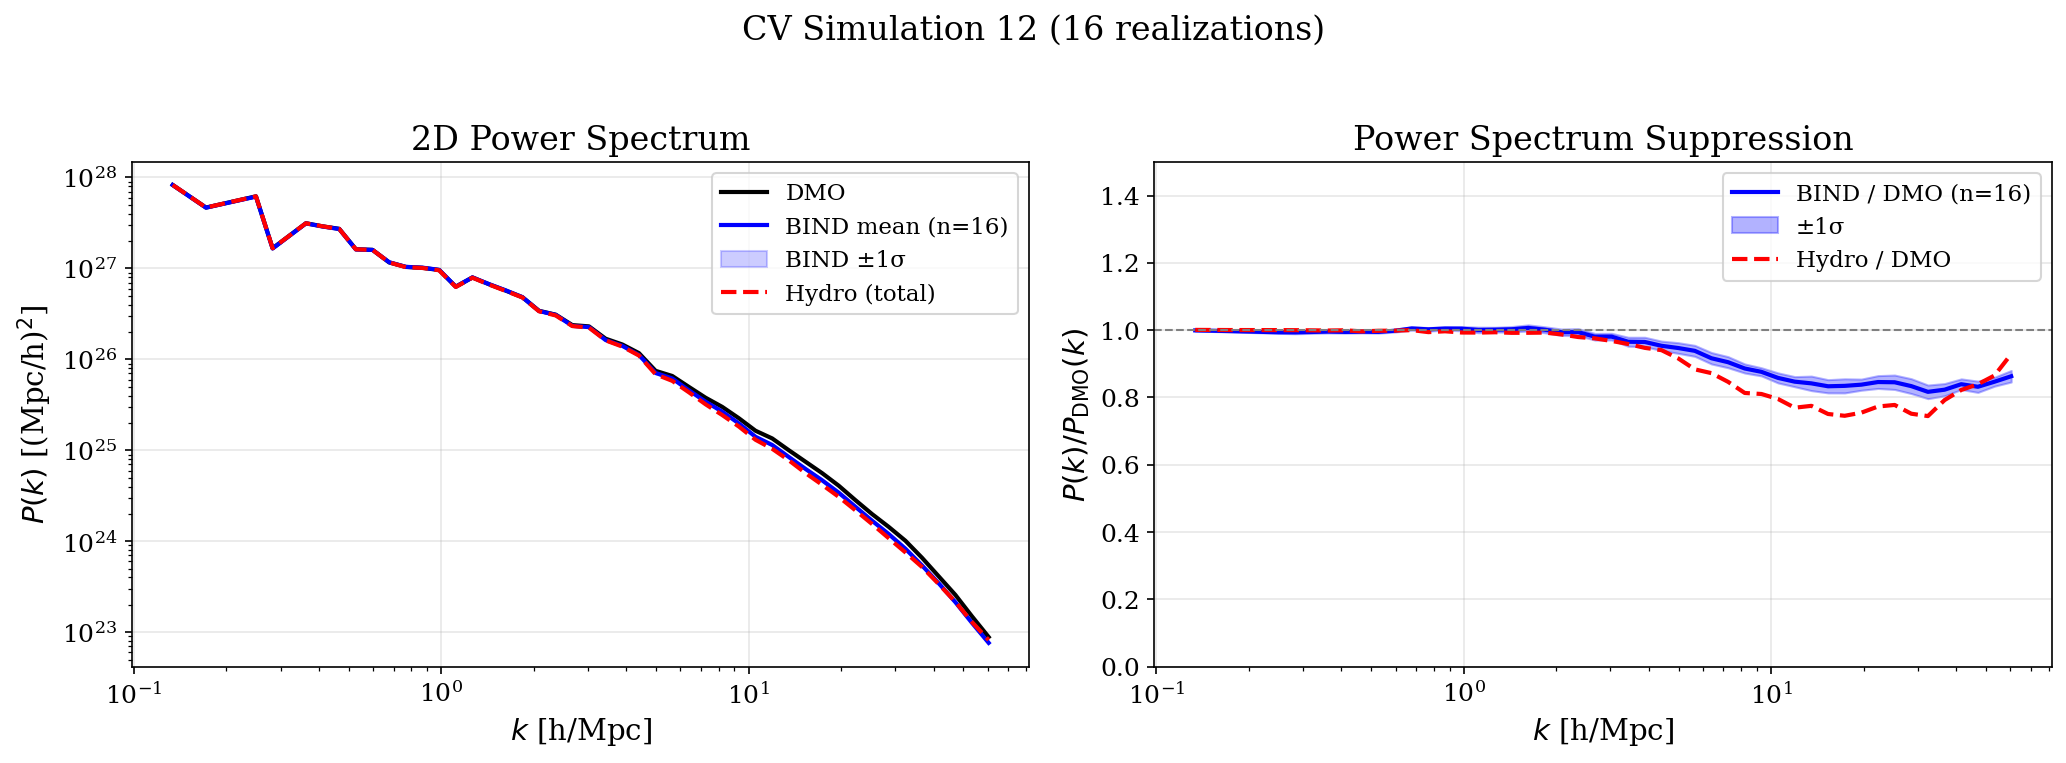

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Interpolate to common k grid
from scipy.interpolate import interp1d

# Use DMO k as reference
k_ref = k_dmo
interp_dmo = interp1d(k_dmo, Pk_dmo, bounds_error=False, fill_value=np.nan)

# Left: Absolute power spectra
ax = axes[0]
ax.loglog(k_dmo, Pk_dmo, 'k-', linewidth=2, label='DMO')
ax.loglog(k_bind, Pk_bind_mean, 'b-', linewidth=2, label=f'BIND mean (n={len(final_maps)})')

# Add shaded region for BIND std
ax.fill_between(k_bind, Pk_bind_mean - Pk_bind_std, Pk_bind_mean + Pk_bind_std,
                color='blue', alpha=0.2, label='BIND ±1σ')

if hydro_fields is not None:
    k_h, Pk_h = Pk_hydro['total']
    ax.loglog(k_h, Pk_h, 'r--', linewidth=2, label='Hydro (total)')

ax.set_xlabel(r'$k$ [h/Mpc]')
ax.set_ylabel(r'$P(k)$ [(Mpc/h)$^2$]')
ax.set_title('2D Power Spectrum')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Power spectrum ratio (suppression) with uncertainty
ax = axes[1]

# Compute ratio for each BIND realization
interp_bind_all = [interp1d(k_bind, Pk_i, bounds_error=False, fill_value=np.nan) 
                   for Pk_i in Pk_bind_all]
ratio_bind_all = np.array([interp_i(k_ref) / interp_dmo(k_ref) for interp_i in interp_bind_all])

# Mean and std of ratios
ratio_bind_mean = np.nanmean(ratio_bind_all, axis=0)
ratio_bind_std = np.nanstd(ratio_bind_all, axis=0)

# Plot mean ratio with shaded uncertainty
ax.semilogx(k_ref, ratio_bind_mean, 'b-', linewidth=2, label=f'BIND / DMO (n={len(final_maps)})')
ax.fill_between(k_ref, ratio_bind_mean - ratio_bind_std, ratio_bind_mean + ratio_bind_std,
                color='blue', alpha=0.3, label='±1σ')

if hydro_fields is not None:
    k_h, Pk_h = Pk_hydro['total']
    interp_hydro = interp1d(k_h, Pk_h, bounds_error=False, fill_value=np.nan)
    ratio_hydro = interp_hydro(k_ref) / interp_dmo(k_ref)
    ax.semilogx(k_ref, ratio_hydro, 'r--', linewidth=2, label='Hydro / DMO')

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel(r'$k$ [h/Mpc]')
ax.set_ylabel(r'$P(k) / P_{\rm DMO}(k)$')
ax.set_title('Power Spectrum Suppression')
ax.set_ylim(0, 1.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'CV Simulation {SIM_NUM} ({len(final_maps)} realizations)', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'cv{SIM_NUM}_power_spectrum.png')
plt.show()

## Per-Channel Power Spectra

In [41]:
channel_names = ['DM Hydro', 'Gas', 'Stars']
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']

# Check if we have 3-channel output
sample_field = final_maps[0]
if sample_field.ndim == 3 and sample_field.shape[0] == 3:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ch_idx, (ax, ch_name, color) in enumerate(zip(axes, channel_names, channel_colors)):
        # Compute power spectrum for each realization for this channel
        Pk_channel_all = []
        k_channel = None
        
        for bind_map in final_maps:
            k_ch, Pk_ch = compute_power_spectrum_2d(bind_map[ch_idx], box_size_mpc)
            Pk_channel_all.append(Pk_ch)
            if k_channel is None:
                k_channel = k_ch
        
        Pk_channel_all = np.array(Pk_channel_all)
        Pk_channel_mean = Pk_channel_all.mean(axis=0)
        Pk_channel_std = Pk_channel_all.std(axis=0)
        
        # Plot mean with shaded std
        ax.loglog(k_channel, Pk_channel_mean, '-', color=color, linewidth=2, 
                  label=f'BIND (n={len(final_maps)})')
        ax.fill_between(k_channel, Pk_channel_mean - Pk_channel_std, 
                       Pk_channel_mean + Pk_channel_std,
                       color=color, alpha=0.2, label='±1σ')
        
        # Hydro channel (if available)
        if hydro_fields is not None:
            hydro_key = ['dm', 'gas', 'stars'][ch_idx]
            if hydro_key in Pk_hydro:
                k_h, Pk_h = Pk_hydro[hydro_key]
                ax.loglog(k_h, Pk_h, '--', color='gray', linewidth=2, label='Hydro')
        
        ax.set_xlabel(r'$k$ [h/Mpc]')
        ax.set_ylabel(r'$P(k)$')
        ax.set_title(ch_name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Per-Channel Power Spectra - CV {SIM_NUM} ({len(final_maps)} realizations)', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    
    fig.savefig(FIGURE_DIR / f'cv{SIM_NUM}_power_spectrum_channels.png')
    plt.show()
else:
    print("BIND output is not 3-channel, skipping per-channel analysis")

BIND output is not 3-channel, skipping per-channel analysis


## Visual Comparison: Full Box Maps

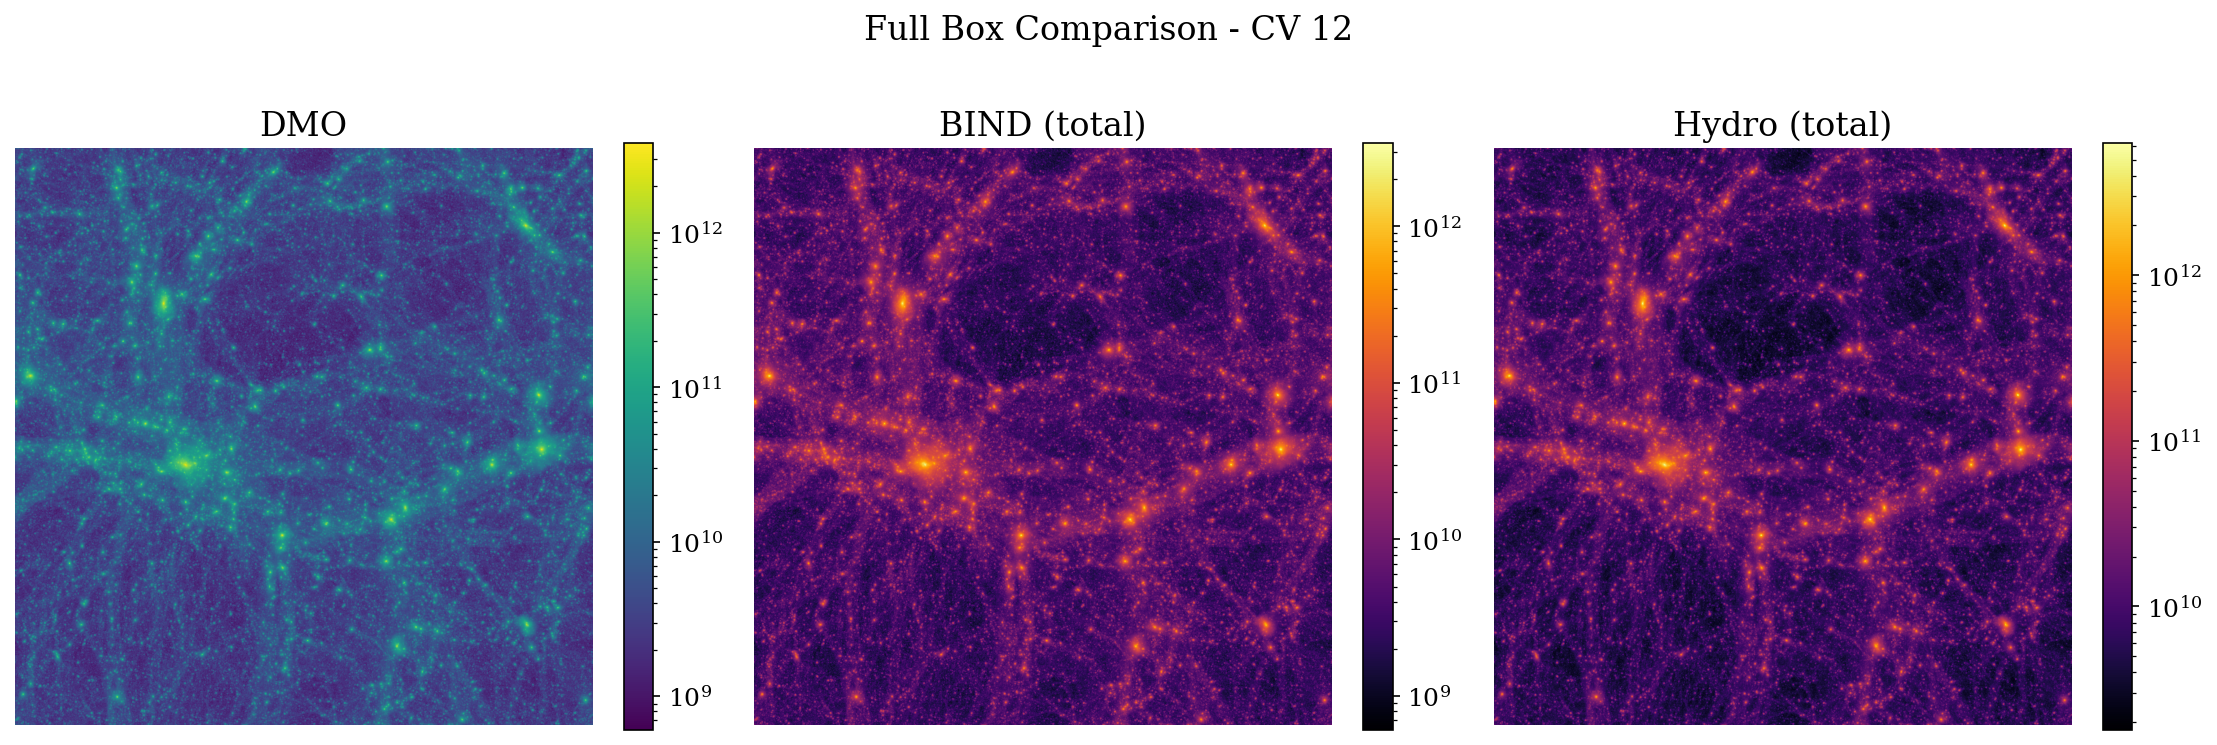

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# DMO
ax = axes[0]
im = ax.imshow(dmo_field, cmap='viridis', norm=LogNorm())
ax.set_title('DMO')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# BIND
ax = axes[1]
im = ax.imshow(bind_total, cmap='inferno', norm=LogNorm())
ax.set_title('BIND (total)')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Hydro
ax = axes[2]
if hydro_fields is not None:
    hydro_total = sum(hydro_fields.values())
    im = ax.imshow(hydro_total, cmap='inferno', norm=LogNorm())
    ax.set_title('Hydro (total)')
else:
    ax.text(0.5, 0.5, 'Hydro not loaded', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Hydro (not available)')
ax.axis('off')
if hydro_fields is not None:
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle(f'Full Box Comparison - CV {SIM_NUM}', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'cv{SIM_NUM}_full_box_comparison.png')
plt.show()

## Summary Statistics

In [ ]:
print(f"\n{'='*60}")
print(f"BIND Analysis Summary - CV {SIM_NUM}")
print(f"{'='*60}\n")

# Config info
config = ConfigLoader(str(CONFIG_PATH), verbose=False)
print(f"Model: {config.model_name}")
print(f"Checkpoint: {Path(config.best_ckpt).name}")
print()

# Simulation info
print(f"Simulation:")
print(f"  CV number: {SIM_NUM}")
print(f"  Box size: {BOX_SIZE/1000:.1f} Mpc/h")
print(f"  Grid: {GRID_SIZE}^2")
print(f"  Halos processed: {num_halos}")
print(f"  Realizations: {len(final_maps)}")
print()

# Mass comparison (show mean ± std across realizations)
bind_masses = np.array([fm.sum() if fm.ndim == 2 else fm.sum() for fm in final_maps])
print(f"Total Mass Comparison:")
print(f"  DMO:   {dmo_field.sum():.4e}")
print(f"  BIND:  {bind_masses.mean():.4e} ± {bind_masses.std():.4e}")
if hydro_fields is not None:
    hydro_total_mass = hydro_fields['hydro'].sum()
    print(f"  Hydro: {hydro_total_mass:.4e}")
print()

# Power spectrum comparison at specific k (with uncertainty)
k_ref_vals = [0.5, 1.0, 5.0, 10.0]  # h/Mpc
print(f"Power Spectrum Ratio at specific k (mean ± std over {len(final_maps)} realizations):")
for k_val in k_ref_vals:
    if k_val < k_ref.max() and k_val > k_ref.min():
        idx = np.argmin(np.abs(k_ref - k_val))
        bind_ratio_mean = ratio_bind_mean[idx]
        bind_ratio_std = ratio_bind_std[idx]
        if hydro_fields is not None:
            hydro_ratio_val = ratio_hydro[idx]
            print(f"  k={k_val:.1f}: BIND/DMO={bind_ratio_mean:.3f}±{bind_ratio_std:.3f}, Hydro/DMO={hydro_ratio_val:.3f}")
        else:
            print(f"  k={k_val:.1f}: BIND/DMO={bind_ratio_mean:.3f}±{bind_ratio_std:.3f}")


BIND Analysis Summary - CV 12

Model: triple_vdm_separate_models
Checkpoint: elbo=-5.383.ckpt

Simulation:
  CV number: 12
  Box size: 50.0 Mpc/h
  Grid: 1024^2
  Halos processed: 36

Total Mass Comparison:
  DMO:   1.0408e+16
  BIND:  1.0391e+16
  Hydro: 1.0408e+16

Power Spectrum Ratio at specific k:
  k=0.5: BIND/DMO=0.997, Hydro/DMO=0.998
  k=1.0: BIND/DMO=1.014, Hydro/DMO=0.993
  k=5.0: BIND/DMO=0.949, Hydro/DMO=0.916
  k=10.0: BIND/DMO=0.856, Hydro/DMO=0.795


## Compare Multiple Models (Optional)

In [ ]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = False

if COMPARE_MODELS:
    print("Model comparison enabled - this will run BIND for multiple models")
    print("This may take a while...")
    
    # Models to compare
    MODELS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'Clean 3ch', '#1f77b4'),
        ('clean_vdm_triple.ini', 'Triple', '#ff7f0e'),
    ]
    
    comparison_results = {}
    
    for config_file, label, color in MODELS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
        
        print(f"\nRunning BIND with {label}...")
        
        # Initialize BIND with this config
        bind_cmp = BIND(
            simulation_path=str(DMO_PATH),
            snapnum=SNAPNUM,
            boxsize=BOX_SIZE,
            gridsize=GRID_SIZE,
            config_path=str(config_path),
            output_dir=str(OUTPUT_DIR / label.replace(' ', '_')),
            verbose=False,
            dim='2d',
            axis=2,
            r_in_factor=2,
            r_out_factor=3,
            mass_threshold=1e13
        )
        
        # Run pipeline
        bind_cmp.voxelize_simulation()
        bind_cmp.extract_halos(omega_m=0.3, use_large_scale=True, num_large_scales=3)
        
        n_halos = len(bind_cmp.extracted['metadata'])
        cond_params = np.tile(fiducial_params, (n_halos, 1)) if fiducial_params else None
        
        bind_cmp.generate_halos(batch_size=16, conditional_params=cond_params,
                               use_large_scale=True, conserve_mass=True)
        final_maps_cmp = bind_cmp.paste_halos(realizations=1, use_enhanced=True)
        
        # Compute power spectrum
        bind_field_cmp = final_maps_cmp[0]
        if bind_field_cmp.ndim == 3:
            bind_total_cmp = bind_field_cmp.sum(axis=0)
        else:
            bind_total_cmp = bind_field_cmp
        
        k_cmp, Pk_cmp = compute_power_spectrum_2d(bind_total_cmp, box_size_mpc)
        
        comparison_results[label] = {
            'k': k_cmp,
            'Pk': Pk_cmp,
            'color': color
        }
        print(f"  Done.")
    
    # Plot comparison
    if comparison_results:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for label, data in comparison_results.items():
            interp_cmp = interp1d(data['k'], data['Pk'], bounds_error=False, fill_value=np.nan)
            ratio = interp_cmp(k_ref) / interp_dmo(k_ref)
            ax.semilogx(k_ref, ratio, '-', color=data['color'], linewidth=2, label=f'{label} / DMO')
        
        if hydro_fields is not None:
            ax.semilogx(k_ref, ratio_hydro, 'k--', linewidth=2, label='Hydro / DMO')
        
        ax.axhline(y=1, color='gray', linestyle=':', linewidth=1)
        ax.set_xlabel(r'$k$ [h/Mpc]')
        ax.set_ylabel(r'$P(k) / P_{\rm DMO}(k)$')
        ax.set_title(f'Model Comparison - CV {SIM_NUM}')
        ax.set_ylim(0, 1.5)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        fig.savefig(FIGURE_DIR / f'cv{SIM_NUM}_model_comparison.png')
        plt.show()